In [ ]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Define your DQN class and functions
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load and preprocess your video dataset
video_dataset = '/Users/martinprabhu/pythonObject1/output.mp4'
cap = cv2.VideoCapture(video_dataset)

def preprocess_frame(frame):
    # Resize the frame to a specific size
    new_width = 224
    new_height = 224
    resized_frame = cv2.resize(frame, (new_width, new_height))

    return resized_frame

# Initialize necessary variables and hyperparameters
state_size = 224 * 224 * 3  # Modify according to your input state dimensions
action_size = 2  # Modify according to your action space size

batch_size = 64
learning_rate = 0.001
num_episodes = 500
num_steps = 100
target_update_freq = 10
num_frames = 3  # Number of frames to stack for the state

epsilon = 1.0
epsilon_decay = 0.99
epsilon_min = 0.01
gamma = 0.99

# Create an instance of the DQN class
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn = DQN(state_size, action_size).to(device)
target_dqn = DQN(state_size, action_size).to(device)
target_dqn.load_state_dict(dqn.state_dict())
target_dqn.eval()

optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Initialize replay memory
replay_memory = []

# Random collision detection function (placeholder implementation)
def check_collision(frame, collision_prob=0.1):
    # Simulate collision with probability collision_prob
    return np.random.rand() < collision_prob

# Start training the DQN network
for episode in range(num_episodes):
    cap = cv2.VideoCapture(video_dataset)
    done = False
    total_reward = 0

    for step in range(num_steps):
        ret, frame = cap.read()
        if not ret:
            break

        frame = preprocess_frame(frame)

        state = frame.flatten()

        # Choose an action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.randint(action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = target_dqn(state_tensor)
            action = torch.argmax(q_values).item()

        # Perform the action and get the next state, reward, and done signal
        # Perform your object tracking action here and update the state, reward, and done signal accordingly

        # Simulate a random collision
        collides = check_collision(frame)

        # Assuming you have information about the bounding box height, bbox_height (replace 0 with the actual value)
        bbox_height = 0
        img_height = frame.shape[0]

        # Update the reward based on the specified conditions
        if collides:
            reward = -1
        elif bbox_height > 36:
            reward = -bbox_height / img_height
        elif bbox_height < 7.2:
            # Handling division by zero
            if bbox_height == 0:
                reward = -1  # Set a specific value to indicate that the condition is not satisfied
            else:
                reward = -img_height / bbox_height
        else:
            reward = 0

        next_state = frame.flatten()

        # Store the transition in the replay memory
        replay_memory.append((state, action, reward, next_state, done))

        # Update the state
        state = next_state
        total_reward += reward

        # Perform the DQN network update
        if len(replay_memory) >= batch_size:
            batch = random.sample(replay_memory, batch_size)
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

            state_batch_array = np.array(state_batch)
            state_batch_tensor = torch.FloatTensor(state_batch_array).to(device)
            action_batch_tensor = torch.LongTensor(action_batch).unsqueeze(1).to(device)
            reward_batch_tensor = torch.FloatTensor(reward_batch).unsqueeze(1).to(device)
            next_state_batch_array = np.array(next_state_batch)
            next_state_batch_tensor = torch.FloatTensor(next_state_batch_array).to(device)
            done_batch_tensor = torch.FloatTensor(done_batch).unsqueeze(1).to(device)

            q_values = dqn(state_batch_tensor).gather(1, action_batch_tensor)
            target_q_values = target_dqn(next_state_batch_tensor).max(1)[0].unsqueeze(1).detach()
            target_q_values = reward_batch_tensor + gamma * target_q_values * (1 - done_batch_tensor)

            loss = criterion(q_values, target_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update the target network
        if step % target_update_freq == 0:
            target_dqn.load_state_dict(dqn.state_dict())

        if done:
            break

    cap.release()  # Release the video capture

    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Print episode statistics
    print("Episode: {}, Total Reward: {}, Epsilon: {:.4f}".format(episode, total_reward, epsilon))


/var/folders/bp/6nr_cvms0_x4_qdd1ntdd17c0000gn/T/ipykernel_11566/350930478.py:52: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/var/folders/bp/6nr_cvms0_x4_qdd1ntdd17c0000gn/T/ipykernel_11566/350930478.py:68: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



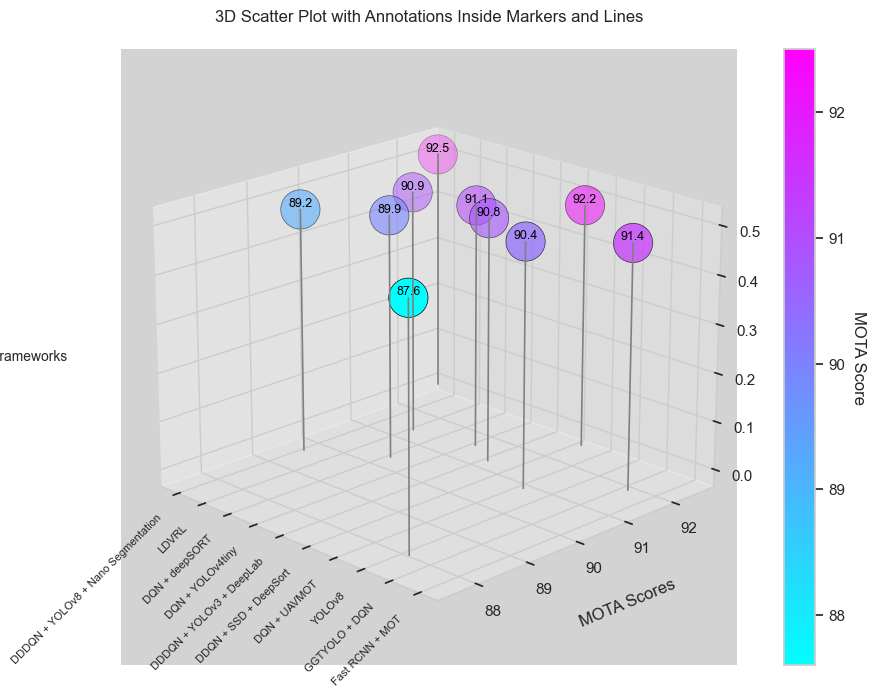

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np

# List of frameworks
frameworks = [
    "DDDQN + YOLOv8 + Nano Segmentation",
    "LDVRL",
    "DQN + deepSORT",
    "DQN + YOLOv4tiny",
    "DDDQN + YOLOv3 + DeepLab",
    "DDQN + SSD + DeepSort",
    "DQN + UAVMOT",
    "YOLOv8",
    "GGTYOLO + DQN",
    "Fast RCNN + MOT"
]

# List of MOTA scores
mota_scores = [
    92.5, 89.2, 90.9, 89.9, 91.1, 90.8, 92.2, 90.4, 87.6, 91.4
]

# Create a figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a fixed z-coordinate
z_coordinate = 0.5

# Create a 3D scatter plot with custom colors and larger markers
scatter = ax.scatter(np.arange(len(frameworks)), mota_scores, [z_coordinate]*len(frameworks), c=mota_scores, cmap='cool', s=800, marker='o', edgecolor='black', linewidth=0.5)

# Annotate scatter plot points with MOTA scores inside the scatter markers
for i, (x, y) in enumerate(zip(np.arange(len(frameworks)), mota_scores)):
    ax.text(x, y, z_coordinate, f'{y:.1f}', ha='center', va='bottom', fontsize=9, color='black')

# Create lines connecting the scatter plot points
for x, y in enumerate(mota_scores):
    ax.plot([x, x], [y, y], [0, z_coordinate], color='gray', linewidth=1.2)

# Customize the axes
ax.set_xticks(np.arange(len(frameworks)))
ax.set_xticklabels(frameworks, rotation=45, ha='right', fontsize=8)
ax.set_xlabel('')
ax.set_ylabel('MOTA Scores', labelpad=15)
ax.set_zlabel('')
ax.set_title('3D Scatter Plot with Annotations Inside Markers and Lines', pad=20)

# Add color bar
cbar = plt.colorbar(scatter, pad=0.05)
cbar.set_label('MOTA Score', rotation=270, labelpad=15)

# Rotate the plot for better visibility
ax.view_init(elev=20, azim=-45)

# Set background color
ax.set_facecolor('lightgray')

# Set grid color
ax.grid(color='white', linestyle='dotted')

# Add "Frameworks" label inside the graph area
ax.text(len(frameworks)/2, np.min(mota_scores) - 5, z_coordinate, 'Frameworks', ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/bp/6nr_cvms0_x4_qdd1ntdd17c0000gn/T/ipykernel_11566/755972720.py:25: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



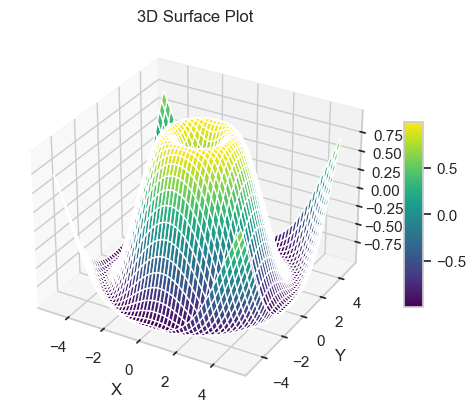

In [102]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of X, Y values
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)

# Create a synthetic Z value based on X, Y
Z = np.sin(np.sqrt(X**2 + Y**2))

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Surface Plot')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.show()
